In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

## 4.2 Accuracy and dummy model


In [10]:
len(y_val)

1409

In [11]:
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8055358410220014

In [13]:
thresholds = np.linspace(0,1,21)
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


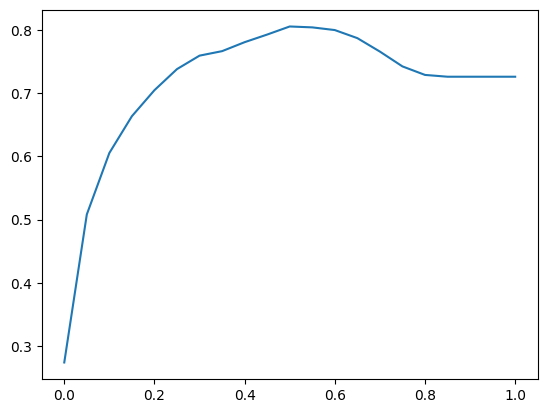

In [14]:
plt.plot(thresholds,scores)

In [15]:
from collections import Counter

In [16]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [17]:
1 - y_val.mean()

np.float64(0.7260468417317246)

## 4.3 Confusion table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [20]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [21]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[923, 100],
       [174, 212]])

In [22]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.12, 0.15]])

In [23]:
confusion_matrix.sum()

np.int64(1409)

## 4.4 Precision and Recall


In [24]:
p = tp / (fp + tp)
p

np.float64(0.6794871794871795)

In [25]:
r = tp / (tp + fn)
r

np.float64(0.5492227979274611)

## 4.5 ROC Curves

In [26]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [27]:
fpr = fp / (fp + tn)
fpr

np.float64(0.09775171065493646)

In [28]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [29]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

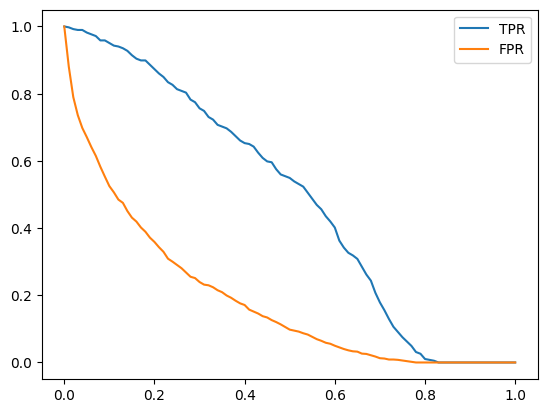

In [30]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

## Random model

In [31]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [32]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)